In [1]:
# Imports

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OS and helpers
from glob import glob, iglob
from collections import defaultdict
import os
import random
from PIL import Image
import multiprocessing
import time
import zipfile

In [2]:
# Settings and hyperparameters

# Image viewing settings
def show_img(img, text=None, should_save=False):
    plt.axis("off")
    if text: plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Loss plot settings
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

##Set core count to total number of cores -1 (could change to half for slower and less taxing performance)
num_workers = max(1, multiprocessing.cpu_count() - 1)

In [4]:
# Exract training, validation, and test images

# Define file paths
train_zip_path = '/kaggle/input/recognizing-faces-in-the-wild/train.zip'
test_zip_path = '/kaggle/input/recognizing-faces-in-the-wild/test.zip'

# Open zip files
with zipfile.ZipFile(train_zip_path, 'r') as train_zip, zipfile.ZipFile(test_zip_path, 'r') as test_zip:
    
    # Get list of all image file paths in the zip
    all_images = [f for f in train_zip.namelist() if f.endswith('.jpg')]
    test_images = [f for f in test_zip.namelist() if f.endswith('.jpg')]

    # Split validation families
    val_famillies = "F09"

    # Separate training and validation images
    train_images = [x for x in all_images if val_famillies not in x]
    val_images = [x for x in all_images if val_famillies in x]


    # Create combined person/image pairs for training set
    person_image_map_train = defaultdict(list)
    for x in train_images:
        normalized_path = os.path.normpath(x)
        path_components = normalized_path.split(os.sep)
        person_id = f"{path_components[-3]}/{path_components[-2]}"
        person_image_map_train[person_id].append(x)

    # Create combined person/image pairs for validation set
    person_image_map_val = defaultdict(list)
    for x in val_images:
        normalized_path = os.path.normpath(x)
        path_components = normalized_path.split(os.sep)
        person_id = f"{path_components[-3]}/{path_components[-2]}"
        person_image_map_val[person_id].append(x)



print("Training images:", len(person_image_map_train))
print("Validation images:", len(person_image_map_val))

Training images: 2085
Validation images: 231


In [5]:
# Create training and validation pairs

# Create a list of all people
person_id=[]
for x in all_images:
    # Normalize the path to handle different OS path separators
    normalized_path = os.path.normpath(x)

    # Split the normalized path into components
    path_components = normalized_path.split(os.sep)

    # Extract the desired components
    person_id.append( f"{path_components[-3]}/{path_components[-2]}")

# Extract all relationships
relationships = pd.read_csv("/kaggle/input/recognizing-faces-in-the-wild/train_relationships.csv")
relationships = list(zip(relationships.p1.values, relationships.p2.values))

# Filter unused relationships and split between train and val
relationships = [x for x in relationships if x[0] in person_id and x[1] in person_id]
pairs_train = [x for x in relationships if val_famillies not in x[0]]
pairs_val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(pairs_train))
print("Total val pairs:", len(pairs_val))

Total train pairs: 3066
Total val pairs: 296


In [6]:
# Dataset definition
class trainingDataset(Dataset):

    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.relationships = relationships # Choose between train and val
        self.transform = transform

    # Allows setting number of pairs in each epoch
    def __len__(self):
        return len(self.relationships)

    # For each relationship retrieves person and either a related person or random unrelated person
    def __getitem__(self,index):
        img0_info = self.relationships[index][0]
        img0_path = glob(train_dataset_path+'/'+img0_info+"/*.jpg")
        
        # Check if `glob` returned any files
        if not img0_path:
            raise IndexError(f"No images found for {img0_path}")
        
        img0_path = random.choice(img0_path)

        # Get related people
        relatives = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info]

        # If no relationship, get a random person (shouldn't trigger)
        if relatives==[]:
            assign_related = 0

        # If there are relationships randomly assign either a related person or an unrelated person
        else:
            assign_related = random.randint(0,1)

        # If assigning a relative, get a related person
        if assign_related==1:
            img1_info = random.choice(relatives)
            if img1_info[0]!=img0_info:
                img1_info=img1_info[0]
            else:
                img1_info=img1_info[1]

            # Get random image of relative
            img1_path = glob(train_dataset_path+'/'+img1_info+"/*.jpg")
            
            # Check if `glob` returned any files
            if not img1_path:
                raise IndexError(f"No images found for {img1_path}")
            
            img1_path = random.choice(img1_path)

        # If assigning non-relative, get an unrelated person
        else:
            # Get a random person and image
            randChoose = True
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]

                # Normalize the path and split into components
                normalized_path = os.path.normpath(img1_path)
                path_components = normalized_path.split(os.sep)

                # Extract and manually info
                img1_info = f"{path_components[-3]}/{path_components[-2]}"

                randChoose = False

                # Check to make sure the random person is not related
                for x in relatives:#if so, randomly choose another person
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        # Any transforms
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , assign_related

In [7]:
# Data loaders

# Hyper Paramters
batch_size=32
epochs=12
img_size=120

transform_list = [transforms.Resize((img_size, img_size)), transforms.ToTensor()]

train_dataset_path = '/kaggle/working/train_dataset'  # Define a persistent directory
test_dataset_path = '/kaggle/working/test_dataset'

# Check if the directory exists
if not os.path.exists(train_dataset_path):
    # Create the directory and unzip the file
    os.makedirs(train_dataset_path, exist_ok=True)
    with zipfile.ZipFile(train_zip_path, 'r') as train_zip:
        train_zip.extractall(train_dataset_path)  # Extract to the persistent directory
        
if not os.path.exists(test_dataset_path):
    # Create the directory and unzip the file
    os.makedirs(test_dataset_path, exist_ok=True)
    with zipfile.ZipFile(test_zip_path, 'r') as test_zip:
        test_zip.extractall(test_dataset_path)  # Extract to the persistent directory

folder_dataset = datasets.ImageFolder(root=train_dataset_path)

train_dataset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=pairs_train,
                                        transform=transforms.Compose(transform_list)
                                        )
val_dataset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=pairs_val,
                                        transform=transforms.Compose(transform_list)
                                        )

train_loader = DataLoader(train_dataset,
                        num_workers=num_workers,
                        batch_size=batch_size,
                        shuffle=True)

val_loader = DataLoader(val_dataset,
                        num_workers=num_workers,
                        batch_size=batch_size,
                        shuffle=True)



In [8]:
# Optional Efficiency tests
image = Image.open(train_dataset_path+"/F0002/MID1/P00010_face4.jpg")

resize_transform = transforms.Resize((img_size, img_size))
to_tensor_transform = transforms.ToTensor()

start_time = time.time()
resized_image = resize_transform(image)
print(f"Resize Time: {time.time() - start_time} seconds")

start_time = time.time()
tensor_image = to_tensor_transform(resized_image)
print(f"ToTensor Time: {time.time() - start_time} seconds")

Resize Time: 0.0035619735717773438 seconds
ToTensor Time: 0.044188737869262695 seconds


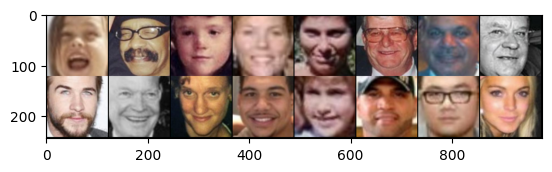

[0 0 1 0 1 0 0 0]


In [9]:
# Optional visualization of images loaded
vis_dataloader = DataLoader(train_dataset,
                        num_workers=num_workers,
                        batch_size=8,
                        shuffle=True)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

# Concatenate each pair of images along the height (dim=1) and make a grid with 8 pairs per row
grid = (
    torchvision.utils.make_grid([torch.cat((img1, img2), 1) for img1, img2 in zip(example_batch[0], example_batch[1])], nrow=8)
    .permute(1, 2, 0)
)

# Display the grid
plt.imshow(grid)
plt.show()

# Print the additional tensor as numpy array
print(example_batch[2].numpy())

In [10]:
# Model Definition
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.3),
        )
        self.fc1 = nn.Linear(2*32*img_size*img_size, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, 2)


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)

        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output
    

In [11]:
# Define training functions
# Function to reset model weights
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# General training and evaluation function
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs, CUDA, opt_name, val_famillies):
    loss_history = []
    iteration_number = []
    start_time = time.time()  # Track time for epoch duration
    
    for epoch in range(epochs):
        running_loss = 0.0
        batch_count = 0
        
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            img0, img1, labels = data
            if CUDA:
                img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(img0, img1)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Collect loss for current optimizer
            if i % 10 == 0:
                iteration_number.append(epoch * len(train_loader) + i)
                loss_history.append(loss.item())

            # Accumulate the running loss
            running_loss += loss.item()
            batch_count += 1

        # Print average loss for the current optimizer after each epoch
        avg_loss = running_loss / batch_count
        print(f"Epoch [{epoch+1}/{epochs}], {opt_name} Average Loss: {avg_loss:.4f}")

        # Validation
        model.eval()  # Set model to evaluation mode
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data in val_loader:
                img0, img1, labels = data
                if CUDA:
                    img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()

                outputs = model(img0, img1)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        accuracy = 100 * correct_val / total_val
        epoch_duration = (time.time() - start_time) / 60  # Calculate duration
        print(f"{opt_name} Accuracy: {accuracy:.2f}% on {total_val} pairs in {val_famillies}")
        print(f"Epoch {epoch + 1} completed in {epoch_duration:.2f} minutes.\n")

        # Reset running_loss for the next epoch
        running_loss = 0.0
    
    return loss_history, iteration_number

In [12]:
# Run Training

# Initialize the model
model = SiameseNetwork()

# Check for CUDA and use if available
CUDA = torch.cuda.is_available()

# Check if multiple GPUs are available and use them
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

if CUDA:
    model = model.cuda()
    print("CUDA")

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizers
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate with Adam
print("Training with Adam optimizer...")
loss_history_adam, iteration_number_adam = train_and_evaluate(
    model, optimizer_adam, criterion, train_loader, val_loader, epochs, CUDA, "Adam", val_famillies
)

# Reset model parameters before training with SGD
print("Resetting model weights...")
model.apply(reset_weights)

# Train and evaluate with SGD
print("Training with SGD optimizer...")
loss_history_sgd, iteration_number_sgd = train_and_evaluate(
    model, optimizer_sgd, criterion, train_loader, val_loader, epochs, CUDA, "SGD", val_famillies
)

CUDA
Training with Adam optimizer...
Epoch [1/12], Adam Average Loss: 5.5306
Adam Accuracy: 49.32% on 296 pairs in F09
Epoch 1 completed in 0.35 minutes.

Epoch [2/12], Adam Average Loss: 0.8015
Adam Accuracy: 50.00% on 296 pairs in F09
Epoch 2 completed in 0.68 minutes.

Epoch [3/12], Adam Average Loss: 0.7228
Adam Accuracy: 55.07% on 296 pairs in F09
Epoch 3 completed in 1.00 minutes.

Epoch [4/12], Adam Average Loss: 0.7039
Adam Accuracy: 51.35% on 296 pairs in F09
Epoch 4 completed in 1.33 minutes.

Epoch [5/12], Adam Average Loss: 0.6909
Adam Accuracy: 52.03% on 296 pairs in F09
Epoch 5 completed in 1.66 minutes.

Epoch [6/12], Adam Average Loss: 0.6936
Adam Accuracy: 57.43% on 296 pairs in F09
Epoch 6 completed in 1.99 minutes.

Epoch [7/12], Adam Average Loss: 0.6834
Adam Accuracy: 58.11% on 296 pairs in F09
Epoch 7 completed in 2.32 minutes.

Epoch [8/12], Adam Average Loss: 0.6898
Adam Accuracy: 54.73% on 296 pairs in F09
Epoch 8 completed in 2.64 minutes.

Epoch [9/12], Adam 

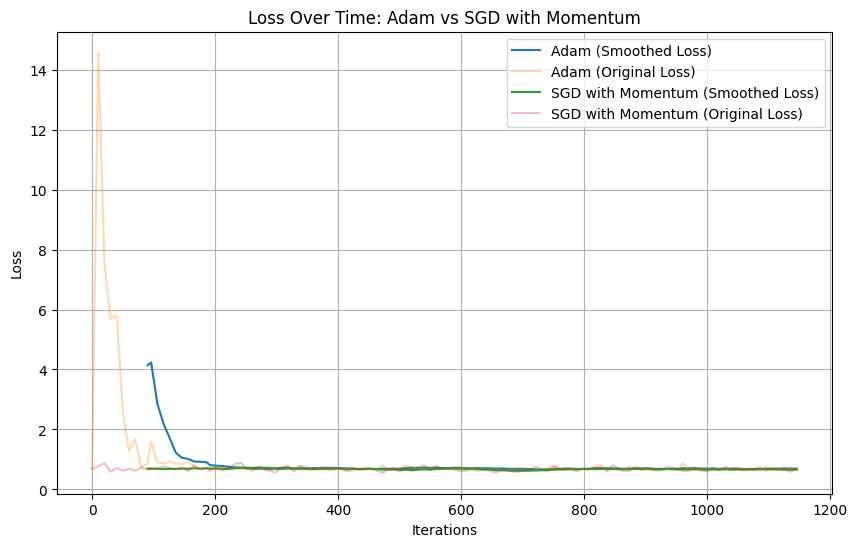

In [13]:
# Moving average function for smoothing
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot losses for Adam and SGD
def show_plot_adam_sgd(iteration_adam, loss_adam, iteration_sgd, loss_sgd, window_size=10):
    smoothed_loss_adam = moving_average(loss_adam, window_size)
    smoothed_loss_sgd = moving_average(loss_sgd, window_size)

    plt.figure(figsize=(10,6))

    # Adam plot
    plt.plot(iteration_adam[len(iteration_adam)-len(smoothed_loss_adam):], smoothed_loss_adam, label="Adam (Smoothed Loss)")
    plt.plot(iteration_adam, loss_adam, alpha=0.3, label="Adam (Original Loss)")

    # SGD plot
    plt.plot(iteration_sgd[len(iteration_sgd)-len(smoothed_loss_sgd):], smoothed_loss_sgd, label="SGD with Momentum (Smoothed Loss)")
    plt.plot(iteration_sgd, loss_sgd, alpha=0.3, label="SGD with Momentum (Original Loss)")

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Over Time: Adam vs SGD with Momentum")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function with Adam and SGD losses
show_plot_adam_sgd(iteration_number_adam, loss_history_adam, iteration_number_sgd, loss_history_sgd)

In [16]:
# SGD with momentum was better - adam overfitting and underperforming consistently. Run SGD again, lower batch size for more randomness in input, lower learning rate, and more epochs

# Set hyper parameters
batch_size=24
epochs=64

# Train and evaluate with SGD
print("Resetting model weights...")
model.apply(reset_weights)

optimizer_sgd = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
print("Training with SGD optimizer...")
loss_history_sgd, iteration_number_sgd = train_and_evaluate(
    model, optimizer_sgd, criterion, train_loader, val_loader, epochs, CUDA, "SGD", val_famillies
)

Resetting model weights...
Training with SGD optimizer...
Epoch [1/64], SGD Average Loss: 0.7122
SGD Accuracy: 57.09% on 296 pairs in F09
Epoch 1 completed in 0.26 minutes.

Epoch [2/64], SGD Average Loss: 0.6912
SGD Accuracy: 62.84% on 296 pairs in F09
Epoch 2 completed in 0.52 minutes.

Epoch [3/64], SGD Average Loss: 0.6740
SGD Accuracy: 57.09% on 296 pairs in F09
Epoch 3 completed in 0.78 minutes.

Epoch [4/64], SGD Average Loss: 0.6744
SGD Accuracy: 54.73% on 296 pairs in F09
Epoch 4 completed in 1.04 minutes.

Epoch [5/64], SGD Average Loss: 0.6730
SGD Accuracy: 51.01% on 296 pairs in F09
Epoch 5 completed in 1.30 minutes.

Epoch [6/64], SGD Average Loss: 0.6676
SGD Accuracy: 57.09% on 296 pairs in F09
Epoch 6 completed in 1.57 minutes.

Epoch [7/64], SGD Average Loss: 0.6583
SGD Accuracy: 59.80% on 296 pairs in F09
Epoch 7 completed in 1.83 minutes.

Epoch [8/64], SGD Average Loss: 0.6721
SGD Accuracy: 57.09% on 296 pairs in F09
Epoch 8 completed in 2.09 minutes.

Epoch [9/64], 

In [17]:
class testDataset(Dataset):
    def __init__(self, sample_file, transform=None):
        self.test_df = pd.read_csv(sample_file)
        self.transform = transform

    def __getitem__(self, index):
        img0_path, img1_path = self.test_df.iloc[index].img_pair.split("-")
        img0 = Image.open(test_dataset_path + '/' + img0_path)
        img1 = Image.open(test_dataset_path + '/' + img1_path)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)

# Configurations & model placeholder
sample_file = "/kaggle/input/recognizing-faces-in-the-wild/sample_submission.csv"

# Prepare dataset and dataloader
testset = testDataset(sample_file, transform=transforms.Compose(transform_list))
testloader = DataLoader(testset, shuffle=False, num_workers=0, batch_size=1)

# Make predictions
predictions = []
with torch.no_grad():
    for img0, img1 in testloader:
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = model(img0, img1)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu().numpy()[0])

# Update dataframe and save to CSV
test_df = pd.read_csv(sample_file)
test_df['is_related'] = predictions
test_df.to_csv("submission.csv", index=False)
print(test_df.head(50))

                       img_pair  is_related
0   face05508.jpg-face01210.jpg           0
1   face05750.jpg-face00898.jpg           1
2   face05820.jpg-face03938.jpg           1
3   face02104.jpg-face01172.jpg           1
4   face02428.jpg-face05611.jpg           0
5   face01219.jpg-face00274.jpg           0
6   face04262.jpg-face00555.jpg           0
7   face03697.jpg-face01892.jpg           0
8   face03524.jpg-face00319.jpg           1
9   face03410.jpg-face05368.jpg           0
10  face00292.jpg-face06004.jpg           0
11  face00353.jpg-face01203.jpg           1
12  face03140.jpg-face05223.jpg           0
13  face02915.jpg-face03312.jpg           0
14  face03012.jpg-face04103.jpg           0
15  face02240.jpg-face02336.jpg           1
16  face02131.jpg-face05209.jpg           1
17  face04105.jpg-face01209.jpg           0
18  face03565.jpg-face02509.jpg           1
19  face02836.jpg-face01540.jpg           0
20  face02832.jpg-face05386.jpg           1
21  face02596.jpg-face02913.jpg 